# **Predicción del consumo de energía con temperatura**
### **Proyecto Final**

**Mariana Ramirez, Santiago Hoyos y Camila Nahuel**

# retroalmentación

El script presenta una metodología clara y bien estructurada para abordar la relación entre el consumo de energía y la temperatura. La elección del modelo SARIMAX para incorporar variables exógenas es adecuada dada la naturaleza de los datos.

La matriz de correlaciónesta bien, pero es siempre importante profundizar en la interpretación de estas correlaciones para entender mejor su impacto

En el análisis de la predicción del consumo de energía utilizando el modelo SARIMAX, parece que se ha cometido un error sencillo, pero significativo, en la implementación de la función recursive_forecast_SARIMAX. Se estableció los parámetros del modelo como (p, P, q, Q) = (2, 3, 0, 3), d = 0, D = 1 y m = 6. Sin embargo, en la función de predicción recursiva, se utilizan parámetros diferentes, específicamente p = 3, q = 3, d = 1 y m = 4, y se asume que no hay estacionariedad para P y Q.


       for i in range(train_len, total_len, window):
          model = SARIMAX(endog[:i], exog[:i], order=(3,1,3),
                          seasonal_order=(0,0,0,4), simple_differencing=False)
          res = model.fit(disp=False)

El uso incorrecto de los parámetros en la función recursive_forecast_SARIMAX es una omisión que en el caso de ustedes afecta significativamente la precisión de las predicciones del modelo. 


# comentarios  de los comapñeros 

Buena visualización y explicación inicial.
Hablar un poco más sobre lo que estan haciendo, no deja de ser un monton de código
Ninguna
Sería adecuado mencionar y detallar qué se está haciendo en el desarrollo de los modelos. 
Todo bien
Un trabajo muy interesante y bien fundamentado :)


______

El objetivo principal del proyecto es establecer relaciones significativas entre el consumo de energía y la temperatura en Australia, utilizando datos históricos. Se emplea un enfoque de análisis de series temporales para modelar y prever patrones de consumo basados en las variaciones térmicas.

El proyecto se apoya en dos conjuntos de datos clave: datos de temperatura y datos de consumo de energía, ambos recopilados de diversas fuentes para realizar un análisis exhaustivo. A continuación, se presenta un resumen de cada conjunto de datos:

**Datos de Temperatura:**

* *Origen de los Datos:* Los datos de temperatura se obtienen de múltiples fuentes, con enlaces específicos a archivos CSV alojados en GitHub.

* *Variables Relevantes:* Las variables incluyen información detallada sobre la temperatura del aire, temperatura de bulbo húmedo, precipitación, humedad relativa, velocidad y dirección del viento, entre otras.

* *Limpieza y Preprocesamiento:* Se realiza una limpieza exhaustiva, eliminando columnas no únicas, duplicados y fechas adicionales. Las fechas se reformatean para facilitar el análisis temporal, y se aplican ajustes a las columnas de formato de objeto para su mejor manejo.

* *Mapeo Geográfico:* Se asignan regiones geográficas a estaciones meteorológicas específicas, simplificando así la correlación con los datos de consumo de energía.

**Datos de Consumo de Energía:**

* *Origen de los Datos:* Los datos de consumo de energía se recopilan de archivos CSV, organizados por regiones específicas y años, también disponibles en GitHub.

* *Variables Relevantes:* Las variables incluyen información detallada sobre el consumo de energía por fecha y región.

* *Limpieza y Preprocesamiento:* Se aplican técnicas de limpieza para eliminar duplicados y ajustar el formato de fechas. Se asignan nombres descriptivos a las regiones, simplificando la interpretación de los resultados.

* *Índices Temporales:* Se establecen índices temporales en ambos conjuntos de datos, permitiendo una correlación eficiente entre las condiciones meteorológicas y el consumo de energía a lo largo del tiempo.


Los datos se obtuvieron de:
https://github.com/KamWithK/Temp2Enrgy/tree/master

#### Librerias

In [ ]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install sodapy

In [ ]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sodapy import Socrata
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
from tqdm import tqdm_notebook
from itertools import product
from typing import Union


from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX

import seaborn as sns
import statsmodels.api as sm

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

## **Carga de datos**

**Datos de temperatura**

In [ ]:
links = ['https://raw.githubusercontent.com/KamWithK/Temp2Enrgy/master/Data/Temperature/HM01X_Data_023090_999999999743964.txt',
     'https://raw.githubusercontent.com/KamWithK/Temp2Enrgy/master/Data/Temperature/HM01X_Data_040913_999999999743964.txt',
     'https://raw.githubusercontent.com/KamWithK/Temp2Enrgy/master/Data/Temperature/HM01X_Data_066062_999999999743964.txt',
     'https://raw.githubusercontent.com/KamWithK/Temp2Enrgy/master/Data/Temperature/HM01X_Data_086071_999999999743964.txt',
     'https://raw.githubusercontent.com/KamWithK/Temp2Enrgy/master/Data/Temperature/HM01X_Data_086338_999999999743964.txt',
     'https://raw.githubusercontent.com/KamWithK/Temp2Enrgy/master/Data/Temperature/HM01X_Data_094029_999999999743964.txt']
temperature_CSVs = [pd.read_csv(l) for l in links]

In [ ]:
temperature = pd.concat(temperature_CSVs, ignore_index=True)

In [ ]:
temperature.columns = [
    "HM", "StationNumber", "Year1", "Month1", "Day1", "Hour1", "Minute1", "Year", "Month", "Day", "Hour", "Minute", "Precipitation", "PrecipitationQuality",
    "AirTemperature", "AirTemperatureQuality", "WetBulbTemperature", "WetBulbTemperatureQuality", "DewTemperature", "DewTemperatureQuality", "RelativeHumidity",
    "RelativeHumidityQuality", "WindSpeed", "WindSpeedQuality", "WindDirection", "WindDirectionQuality", "WindgustSpeed", "WindgustSpeedQuality", "SeaPressure",
    "SeaPressureQuality", "StationPressure", "StationPressureQuality", "AWSFlag", "#"]

In [ ]:
temperature.head()

,HM,StationNumber,Year1,Month1,Day1,Hour1,Minute1,Year,Month,Day,...,WindDirection,WindDirectionQuality,WindgustSpeed,WindgustSpeedQuality,SeaPressure,SeaPressureQuality,StationPressure,StationPressureQuality,AWSFlag,#
0,hm,23090,2000,1,1,1,0,2000,1,1,...,190,N,24.1,N,1018.9,N,1012.8,N,,#
1,hm,23090,2000,1,1,1,30,2000,1,1,...,200,N,16.6,N,1018.7,N,1012.6,N,,#
2,hm,23090,2000,1,1,2,0,2000,1,1,...,180,N,20.5,N,1018.5,N,1012.4,N,,#
3,hm,23090,2000,1,1,2,30,2000,1,1,...,170,N,18.4,N,1018.3,N,1012.2,N,,#
4,hm,23090,2000,1,1,3,0,2000,1,1,...,150,N,20.5,N,1018.3,N,1012.2,N,,#


**Datos de Energía**

In [ ]:
year = np.arange(2000, 2018).astype(str)
n = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
place = ['NSW1','QLD1','SA1','VIC1']

dfs=[]
for i in place:
  for j in n:
    for k in year:
     url =  'https://raw.githubusercontent.com/KamWithK/Temp2Enrgy/master/Data/Energy/DATA'+k+j+'_'+i+'.csv'
     df = pd.read_csv(url)
     dfs.append(df)

energy = pd.concat(dfs)

In [ ]:
energy.head()

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,2000/01/01 00:30,6763.57,15.64,TRADE
1,NSW1,2000/01/01 01:00,6386.10,14.06,TRADE
2,NSW1,2000/01/01 01:30,5990.80,14.30,TRADE
3,NSW1,2000/01/01 02:00,5655.98,14.28,TRADE
4,NSW1,2000/01/01 02:30,5283.84,14.17,TRADE


## **Limpieza de datos**

In [ ]:
def remove_non_uniques(dataframe: pd.DataFrame, filter = []):
    remove = [name for name, series in dataframe.items() if len(series.unique()) <= 2 and not name in filter]
    dataframe.drop(remove, axis=1, inplace=True)
    return remove

print("Removed:")
remove_non_uniques(energy)
remove_non_uniques(temperature)

Removed:


['HM',
 'PrecipitationQuality',
 'AirTemperatureQuality',
 'WetBulbTemperatureQuality',
 'DewTemperatureQuality',
 'RelativeHumidityQuality',
 'WindSpeedQuality',
 'WindDirectionQuality',
 'WindgustSpeedQuality',
 'SeaPressureQuality',
 'StationPressureQuality',
 '#']

In [ ]:
energy.drop_duplicates(inplace=True)
temperature.drop_duplicates(inplace=True)

In [ ]:
# Remove extra dates
temperature.drop(["Year1", "Month1", "Day1", "Hour1", "Minute1"], axis=1, inplace=True)

# Reformat dates into Pandas' datatime64 objects
# Replacing old format
temperature["Date"] = pd.to_datetime(temperature[["Year", "Month", "Day", "Hour", "Minute"]])
energy["SETTLEMENTDATE"] = pd.to_datetime(energy["SETTLEMENTDATE"])

temperature.drop(["Year", "Month", "Day", "Hour", "Minute"], axis=1, inplace=True)

In [ ]:
def to_object_columns(lambda_function):
    string_columns = temperature.select_dtypes("object").columns
    temperature[string_columns] = temperature[string_columns].apply(lambda_function)

In [ ]:
to_object_columns(lambda column: column.str.strip())

In [ ]:
temperature["AWSFlag"] = temperature["AWSFlag"].replace("", 0).astype("category")
temperature["AWSFlag"].fillna(0, inplace=True)
temperature["RelativeHumidity"] = temperature["RelativeHumidity"].replace("###", np.NaN)

In [ ]:
to_object_columns(lambda column: pd.to_numeric(column))

In [ ]:
temperature.dtypes

StationNumber                  int64
Precipitation                float64
AirTemperature               float64
WetBulbTemperature           float64
DewTemperature               float64
RelativeHumidity             float64
WindSpeed                    float64
WindDirection                float64
WindgustSpeed                float64
SeaPressure                  float64
StationPressure              float64
AWSFlag                     category
Date                  datetime64[ns]
dtype: object

In [ ]:
energy["REGION"].unique()
temperature["StationNumber"].unique()

array([23090, 40913, 66062, 86071, 86338, 94029])

In [ ]:
region_remove_number_map = {"SA1": "SA", "QLD1": "QLD", "NSW1": "NSW", "VIC1": "VIC", "TAS1": "TAS"}
station_to_region_map = {23090: "SA", 40913: "QLD", 66062: "NSW", 86071: "VIC", 94029: "TAS", 86338: "VIC"}

temperature["Region"] = temperature["StationNumber"].map(station_to_region_map)
energy["REGION"] = energy["REGION"].map(region_remove_number_map)

temperature.drop("StationNumber", axis=1, inplace=True)

In [ ]:
energy.set_index("SETTLEMENTDATE", inplace=True)
temperature.set_index("Date", inplace=True)

In [ ]:
temperature = temperature.dropna().drop(columns=['AWSFlag'])

In [ ]:
energy.columns = ['Region','TOTALDEMAND','RRP']

In [ ]:
energy.sort_index(inplace=True)
temperature.sort_index(inplace=True)

data = pd.merge_asof(energy, temperature, left_index=True, right_index=True, by="Region", tolerance=pd.Timedelta("30 min")).dropna()
data

,Region,TOTALDEMAND,RRP,Precipitation,AirTemperature,WetBulbTemperature,DewTemperature,RelativeHumidity,WindSpeed,WindDirection,WindgustSpeed,SeaPressure,StationPressure
SETTLEMENTDATE,,,,,,,,,,,,,
2000-12-10 11:30:00,VIC,5014.09,23.31,0.00,28.90,17.50,8.00,27.00,9.40,100.00,16.60,1009.90,1006.20
2000-12-10 12:00:00,VIC,5036.72,20.31,0.00,29.90,17.20,5.90,22.00,9.40,90.00,16.60,1009.70,1006.00
2000-12-10 12:30:00,VIC,5031.62,21.08,0.00,30.60,17.80,7.00,23.00,11.20,230.00,22.30,1009.50,1005.80
2000-12-10 13:00:00,VIC,5047.23,14.67,0.00,30.90,17.20,4.60,19.00,5.40,280.00,18.40,1009.20,1005.50
2000-12-10 13:30:00,VIC,5063.48,12.75,0.00,31.40,17.80,6.00,20.00,7.60,270.00,14.80,1009.10,1005.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-15 09:30:00,QLD,5684.07,72.20,1.00,19.70,19.00,18.50,93.00,3.60,150.00,22.30,1017.70,1016.70
2017-10-15 10:00:00,QLD,5661.03,72.50,1.00,21.70,19.30,17.90,79.00,14.80,110.00,31.30,1017.50,1016.50
2017-10-15 10:30:00,QLD,5722.26,70.97,1.00,22.40,19.00,16.90,71.00,16.60,110.00,31.30,1017.50,1016.50


## **Análisis exploratorio**

En primer lugar, buscamos entender la relación entre diferentes mediciones que afectan la temperatura y la demanda total de consumo de energía. Para esto, se hace un matriz de correlación.

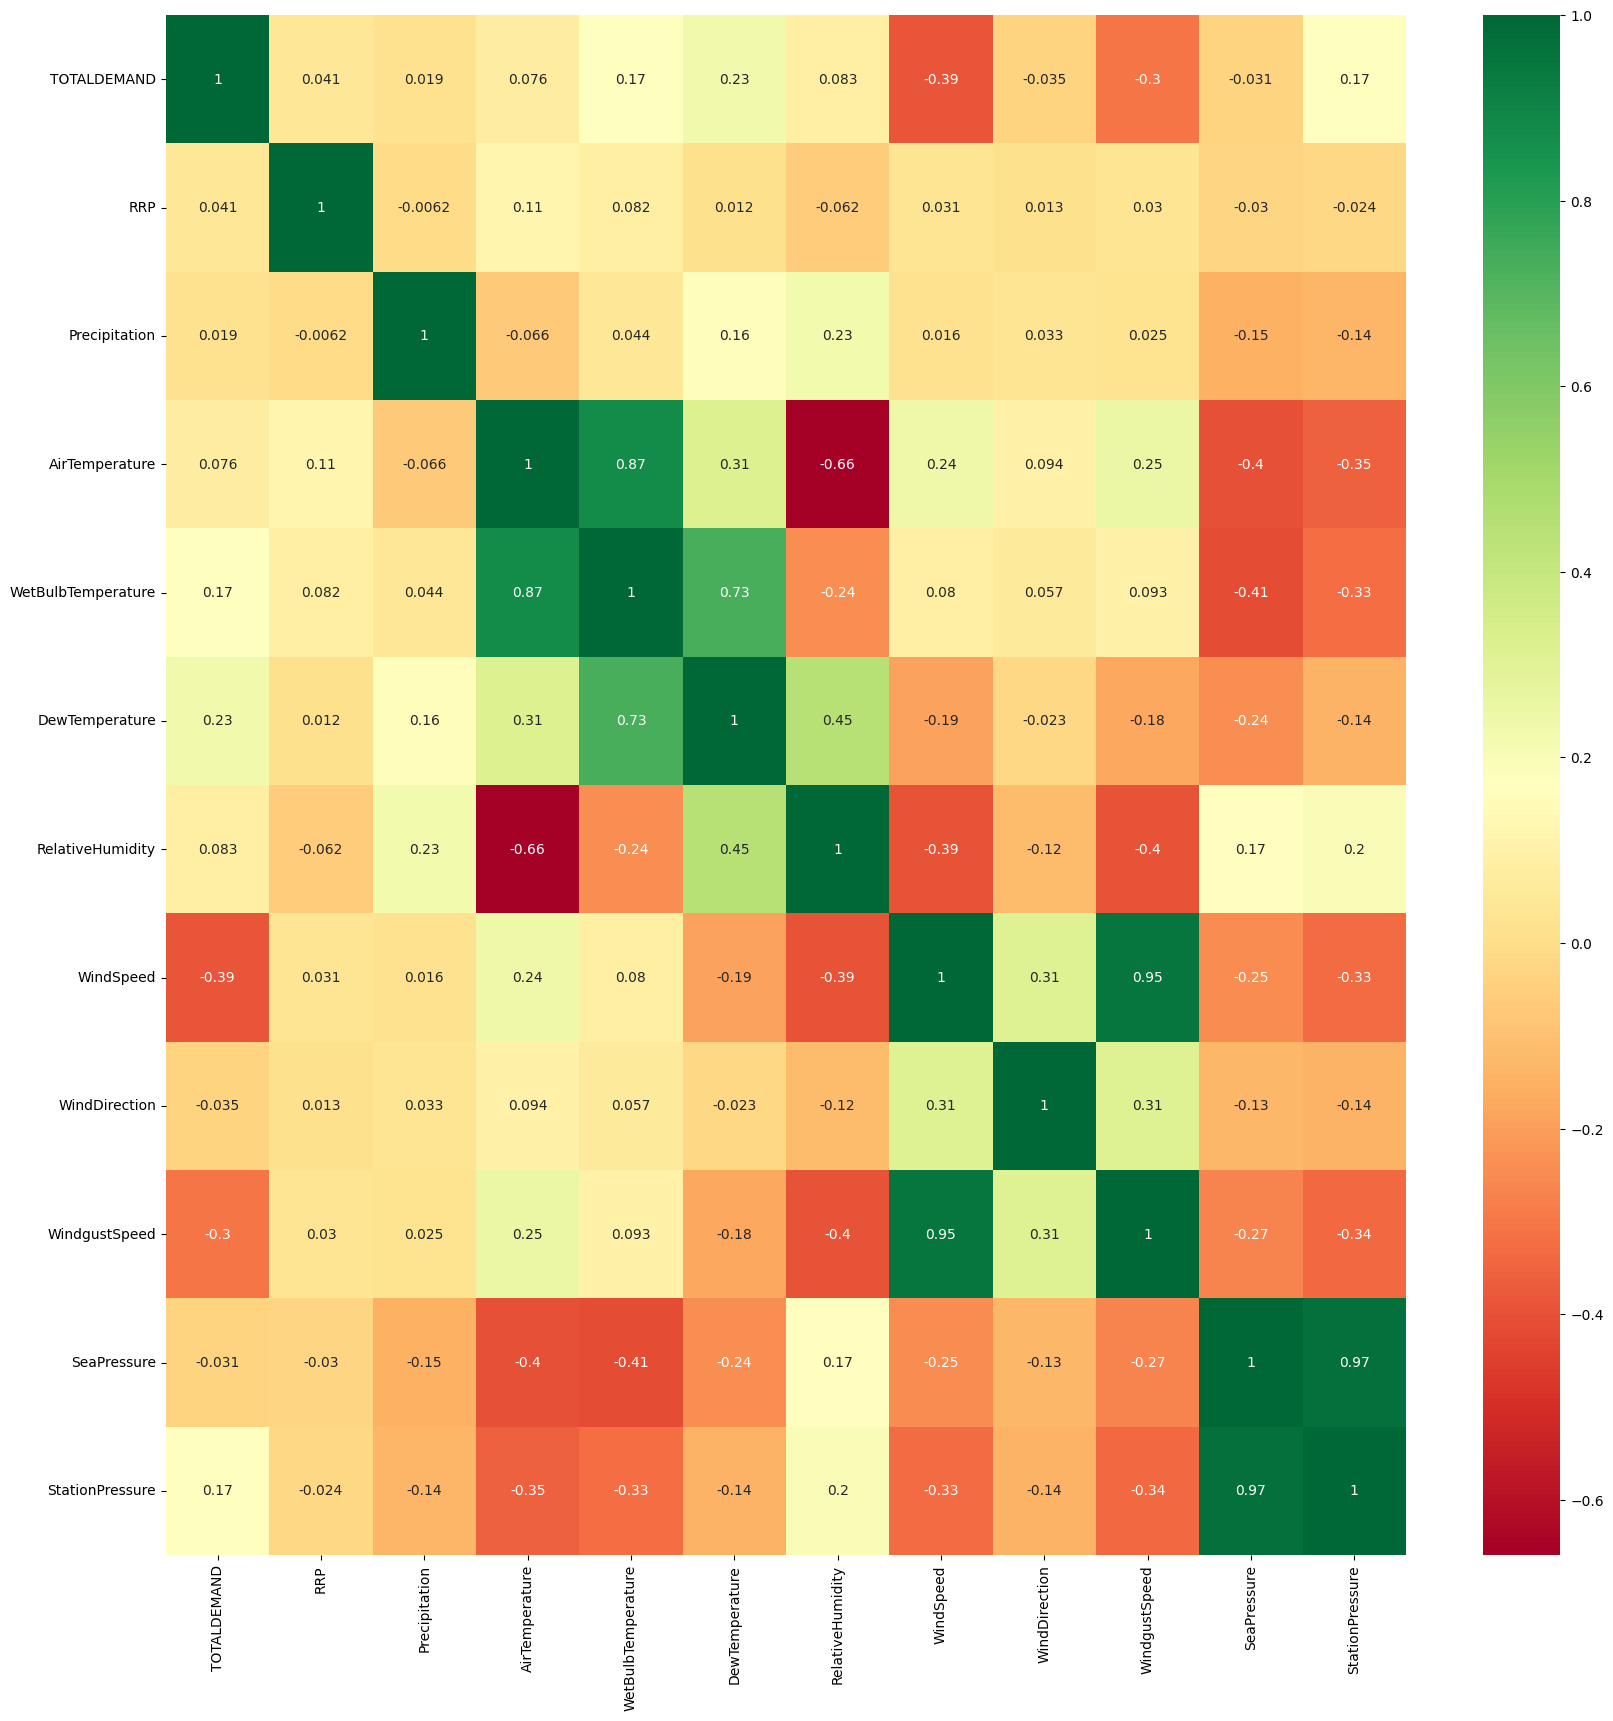

In [ ]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Se puede observar que las correlaciones más altas son:

* Dew temperature (0.23)
* WetBulbTemperature (0.17)
* StationPressure (0.17)

Estas son todas porsitivas. Además se observa correlación alta negativa (-0.33) que significa que entre mayor WindSpeed, menor consumo de energía. Estas sigue afectando altamente a la energía por lo que también se tendrá en cuenta.

En las siguientes gráficas podemos ver la relación lineal de estas variables con las varibles anteriores por región:

#### Victoria

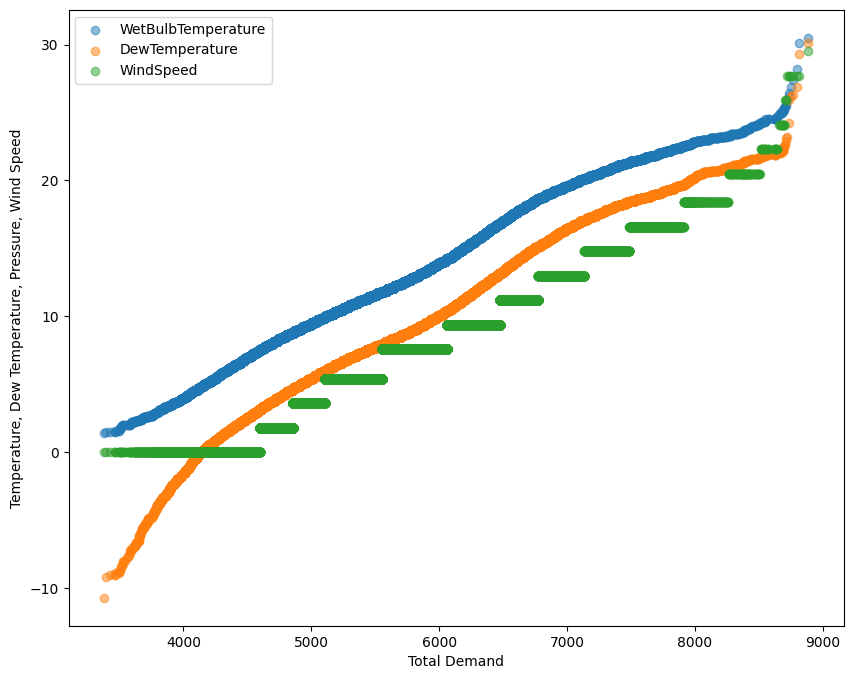

In [ ]:
# Extracting data for WetBulbTemperature
t1 = temperature.groupby("Region").get_group("VIC")["WetBulbTemperature"]["2000":"2017"].sort_values()
e1 = energy.groupby("Region").get_group("VIC")["TOTALDEMAND"]["2000":"2017"].iloc[0:130291].sort_values()

# Extracting data for DewTemperature, StationPressure, and WindSpeed
dew_temp = temperature.groupby("Region").get_group("VIC")["DewTemperature"]["2000":"2017"].iloc[0:315591].sort_values()
station_pressure = temperature.groupby("Region").get_group("VIC")["StationPressure"]["2000":"2017"].iloc[0:315591].sort_values()
wind_speed = temperature.groupby("Region").get_group("VIC")["WindSpeed"]["2000":"2017"].iloc[0:315591].sort_values()

plt.figure(figsize=(10, 8))
# Plotting Total Demand vs WetBulbTemperature
plt.scatter(e1, t1, label='WetBulbTemperature', alpha=0.5)

# Plotting Total Demand vs DewTemperature
plt.scatter(e1, dew_temp, label='DewTemperature', alpha=0.5)

# Plotting Total Demand vs WindSpeed
plt.scatter(e1, wind_speed, label='WindSpeed', alpha=0.5)

# Adding labels and legend
plt.xlabel('Total Demand')
plt.ylabel('Temperature, Dew Temperature, Pressure, Wind Speed')
plt.legend()

# Display the plot
plt.show()


#### Queensland

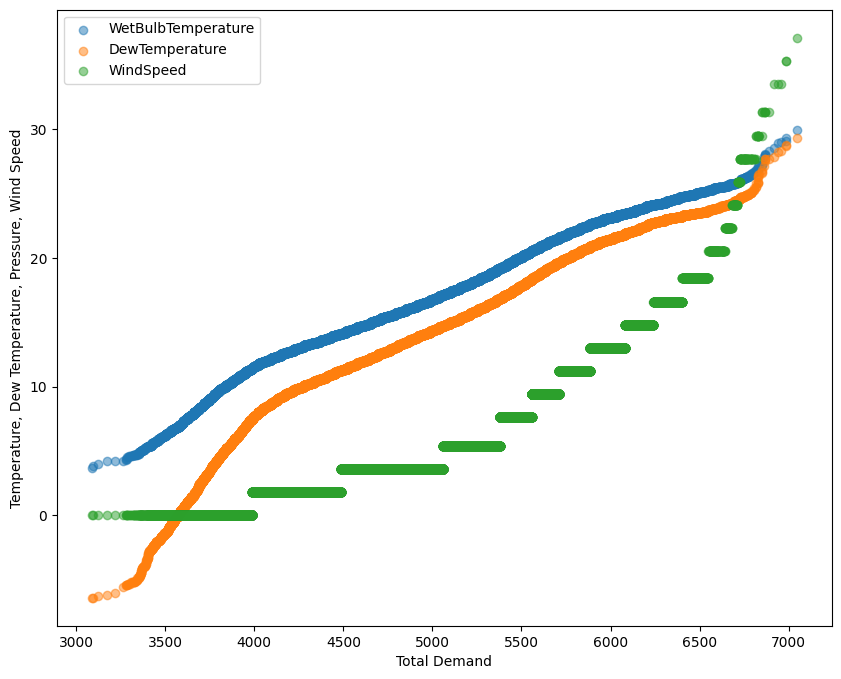

In [ ]:
# Extracting data for WetBulbTemperature
t2 = temperature.groupby("Region").get_group("QLD")["WetBulbTemperature"]["2000":"2017"].sort_values()
e2 = energy.groupby("Region").get_group("QLD")["TOTALDEMAND"]["2000":"2017"].iloc[0:48677].sort_values()

# Extracting data for DewTemperature, StationPressure, and WindSpeed
dew_temp = temperature.groupby("Region").get_group("QLD")["DewTemperature"]["2000":"2017"].iloc[0:315591].sort_values()
station_pressure = temperature.groupby("Region").get_group("QLD")["StationPressure"]["2000":"2017"].iloc[0:315591].sort_values()
wind_speed = temperature.groupby("Region").get_group("QLD")["WindSpeed"]["2000":"2017"].iloc[0:315591].sort_values()

plt.figure(figsize=(10, 8))
# Plotting Total Demand vs WetBulbTemperature
plt.scatter(e2, t2, label='WetBulbTemperature', alpha=0.5)

# Plotting Total Demand vs DewTemperature
plt.scatter(e2, dew_temp, label='DewTemperature', alpha=0.5)

# Plotting Total Demand vs WindSpeed
plt.scatter(e2, wind_speed, label='WindSpeed', alpha=0.5)

# Adding labels and legend
plt.xlabel('Total Demand')
plt.ylabel('Temperature, Dew Temperature, Pressure, Wind Speed')
plt.legend()

# Display the plot
plt.show()

#### South Australia

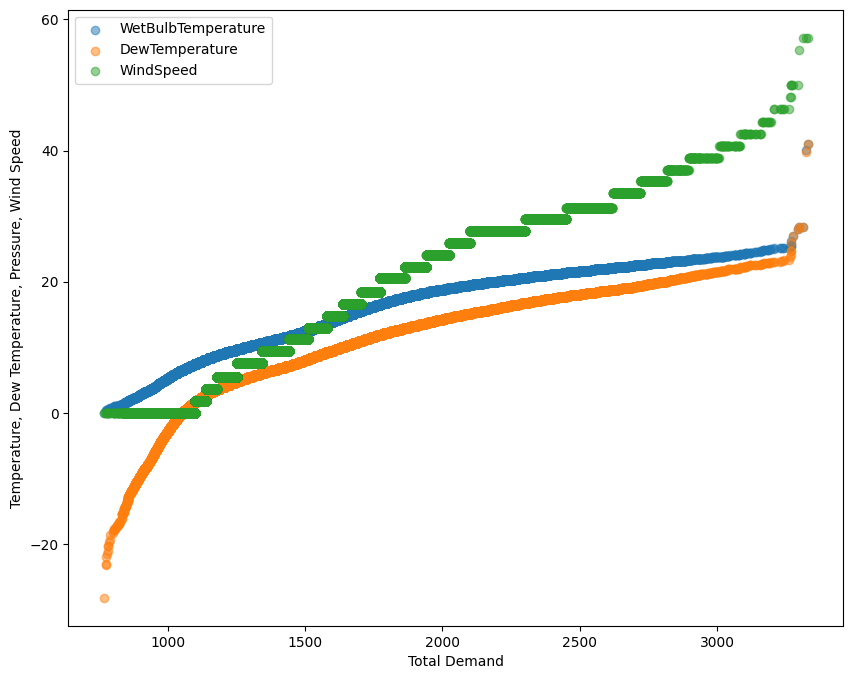

In [ ]:
# Extracting data for WetBulbTemperature
t3 = temperature.groupby("Region").get_group("SA")["WetBulbTemperature"]["2000":"2017"].sort_values()
e3 = energy.groupby("Region").get_group("SA")["TOTALDEMAND"]["2000":"2017"].iloc[0:187953].sort_values()

# Extracting data for DewTemperature, StationPressure, and WindSpeed
dew_temp = temperature.groupby("Region").get_group("SA")["DewTemperature"]["2000":"2017"].iloc[0:315591].sort_values()
wind_speed = temperature.groupby("Region").get_group("SA")["WindSpeed"]["2000":"2017"].iloc[0:315591].sort_values()

plt.figure(figsize=(10, 8))
# Plotting Total Demand vs WetBulbTemperature
plt.scatter(e3, t3, label='WetBulbTemperature', alpha=0.5)

# Plotting Total Demand vs DewTemperature
plt.scatter(e3, dew_temp, label='DewTemperature', alpha=0.5)

# Plotting Total Demand vs WindSpeed
plt.scatter(e3, wind_speed, label='WindSpeed', alpha=0.5)

# Adding labels and legend
plt.xlabel('Total Demand')
plt.ylabel('Temperature, Dew Temperature, Pressure, Wind Speed')
plt.legend()

# Display the plot
plt.show()

Como se puede observar en las gráficas anteriores de consumo de energía vs las características de temperatura con mayor correlación, existe una relación lineal entre estas. Por lo tanto, podemos considerar estas para nuestro modelo sarimax como varibles exógenas.

#### Análisis semanal de la series de tiempo

Por otro lado podemos ver que los datos de energía son tomados cada media hora, por lo que vamos a hacer un promedio diario para poder extraer información más concisa para nuestro modelo.

In [ ]:
e1 = energy.groupby("Region").get_group("VIC")["TOTALDEMAND"]["2000":"2017"].sort_index()
e2 = energy.groupby("Region").get_group("QLD")["TOTALDEMAND"]["2000":"2017"].sort_index()
e3 = energy.groupby("Region").get_group("SA")["TOTALDEMAND"]["2000":"2017"].sort_index()

# Calculate the mean for each day
e1_day = e1.resample('D').mean().dropna()
e2_day = e2.resample('D').mean().dropna()
e3_day = e3.resample('D').mean().dropna()

In [ ]:
t1 = temperature.groupby("Region").get_group("VIC")["2000":"2017"].sort_index()
t2 = temperature.groupby("Region").get_group("QLD")["2000":"2017"].sort_index()
t3 = temperature.groupby("Region").get_group("SA")["2000":"2017"].sort_index()

# Calculate the mean for each day
t1_day = t1.resample('D').mean().dropna()
t2_day = t2.resample('D').mean().dropna()
t3_day = t3.resample('D').mean().dropna()

## **Metodología**

En el proyecto, emplearemos el modelo SARIMAX para pronosticar el consumo de energía semanal por región, teniendo en cuenta el impacto de variables externas como la temperatura, velocidad del viento, presión atmosférica, entre otras.

Para la aplicación de este modelo, es necesario determinar los valores de $p,q, P$ y $Q$, así como los patrones estacionales $m$ que caracterizan nuestro modelo.

Es importante destacar que para cada variable externa en nuestro modelo, se realiza una regresión lineal, contribuyendo así a la incorporación de la información de estas variables en la estructura predictiva del SARIMAX.

Para lograr una comprensión más detallada y aplicada de esta metodología, se sugiere consultar el contenido anterior, que proporciona un contexto más amplio sobre la limpieza de datos, análisis exploratorio y preparación de las series temporales, todos elementos cruciales para la implementación exitosa del modelo SARIMAX.

Las cuatro regiones son Victoria, New South Wales, Queensland y South Australia
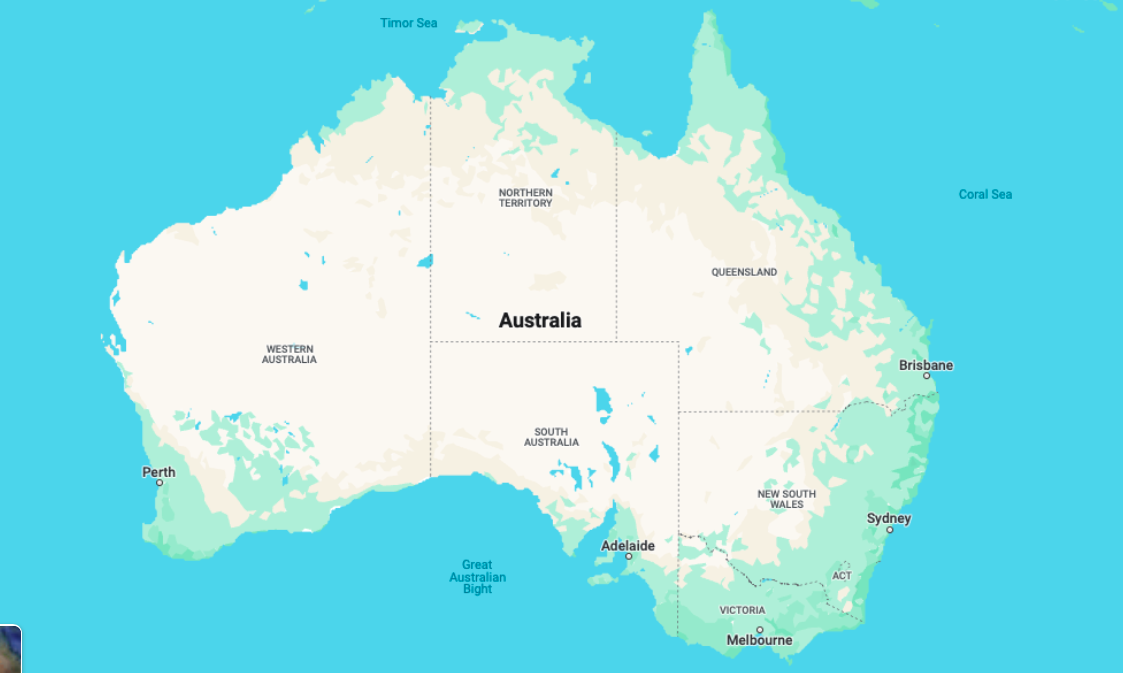

## **Prueba de estacionaridad**





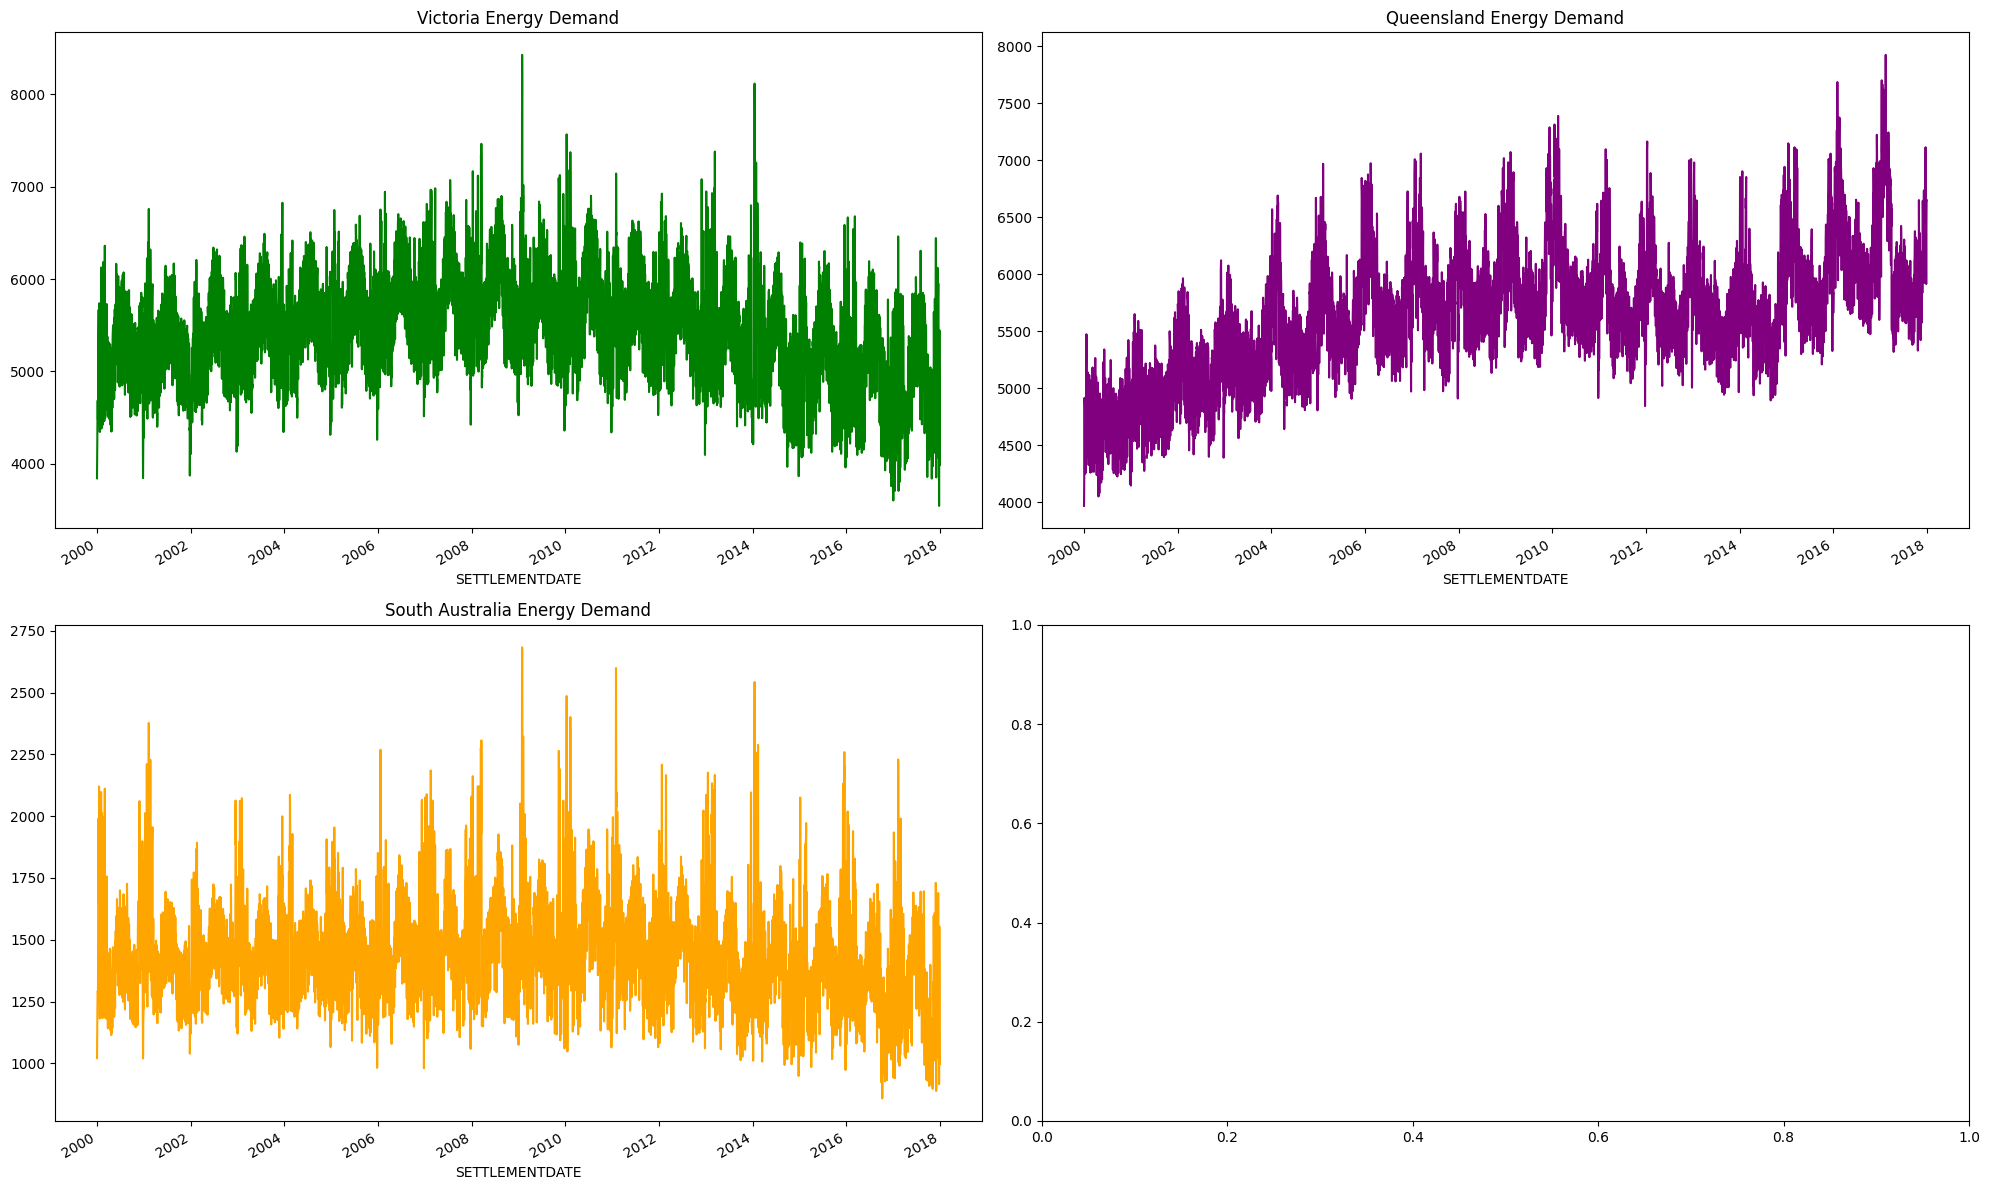

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12), tight_layout=True)

e1_day.plot(color= "green",title="Victoria Energy Demand",ax=axes[0,0]);
e2_day.plot(color= "purple",title="Queensland Energy Demand",ax=axes[0,1]);
e3_day.plot(color= "orange",title="South Australia Energy Demand",ax=axes[1,0]);

In [ ]:
from statsmodels.tsa.stattools import adfuller
def testDF(ts):
  print('Resultados del test  Dickey-Fuller:')
  dftest = adfuller(ts)
  dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
  for key, value in dftest[4].items():
      dfoutput['Critical Value (%s)' %key] = value
  print(dfoutput)

#### Energía

In [ ]:
testDF(e1_day)

Resultados del test  Dickey-Fuller:
Test Statistic                  -5.68
p-value                          0.00
#Lags Used                      35.00
Number of Observations Used   6529.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [ ]:
testDF(e2_day)

Resultados del test  Dickey-Fuller:
Test Statistic                  -4.19
p-value                          0.00
#Lags Used                      35.00
Number of Observations Used   6529.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [ ]:
testDF(e3_day)

Resultados del test  Dickey-Fuller:
Test Statistic                  -8.69
p-value                          0.00
#Lags Used                      35.00
Number of Observations Used   6529.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


Realizando el test de Dickey-Fuller para la estacionaridad por región en la serie de tiempo de energía, se puede observar que todas las serie son estacionarias. Analisando los resultados, el valor negativo del estadístico de prueba es significativamente menor que los valores críticos, lo que indica que la serie temporal es estacionaria. Además, el valor p es extremadamente pequeño (cero), lo que sugiere una fuerte evidencia en contra de la hipótesis nula de no estacionaridad.

## **Prueba de autocorrelación (ACF) y autocorrelacion parcial (PACF)**

Para poder es coger los valores p, q, P, Q y m (temporalidad) para el modelo Sarimax vamos a hacer ACF y PACF para cada serie de tiempo.

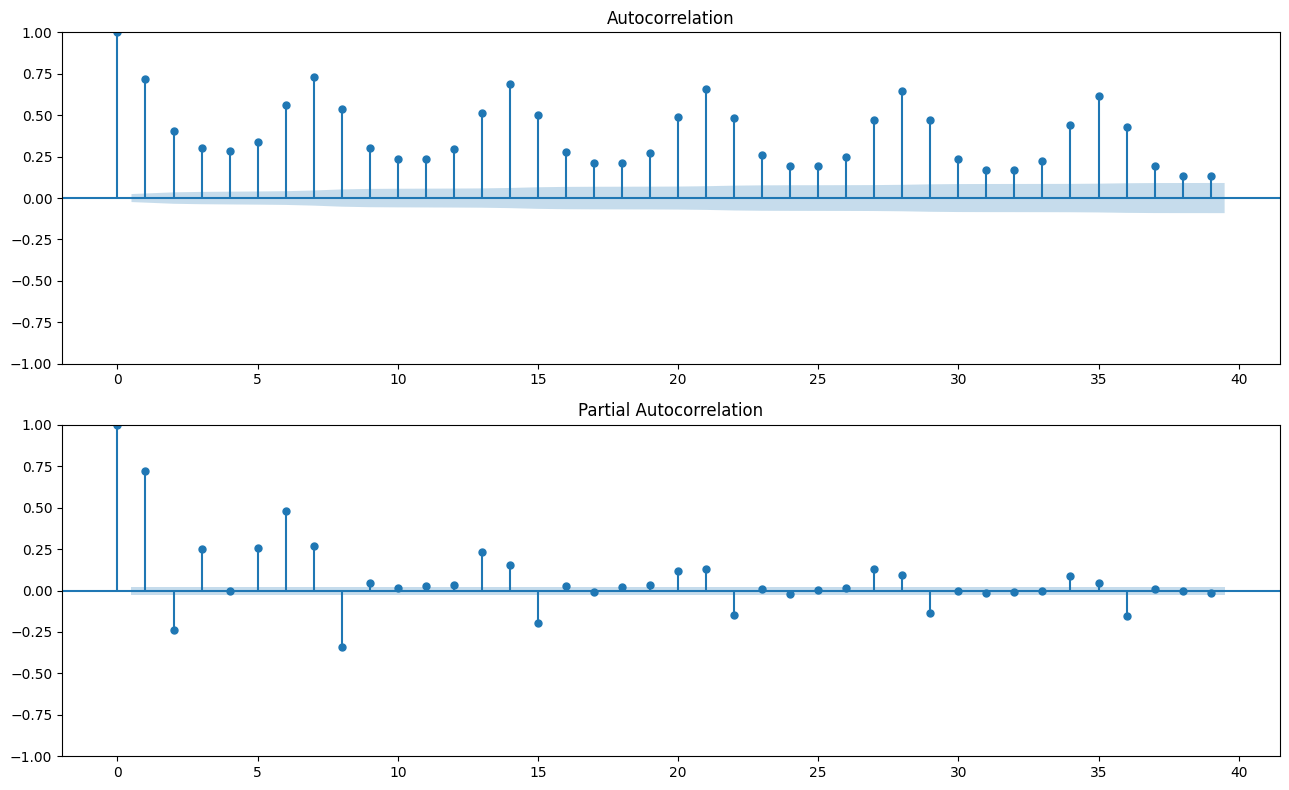

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(13, 8))

# Perform autocorrelation and partial autocorrelation plots
plot_acf(e1_day, ax=axs[0])
axs[0].set_title('Autocorrelation')

plot_pacf(e1_day, ax=axs[1])
axs[1].set_title('Partial Autocorrelation')

# Adjust the layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

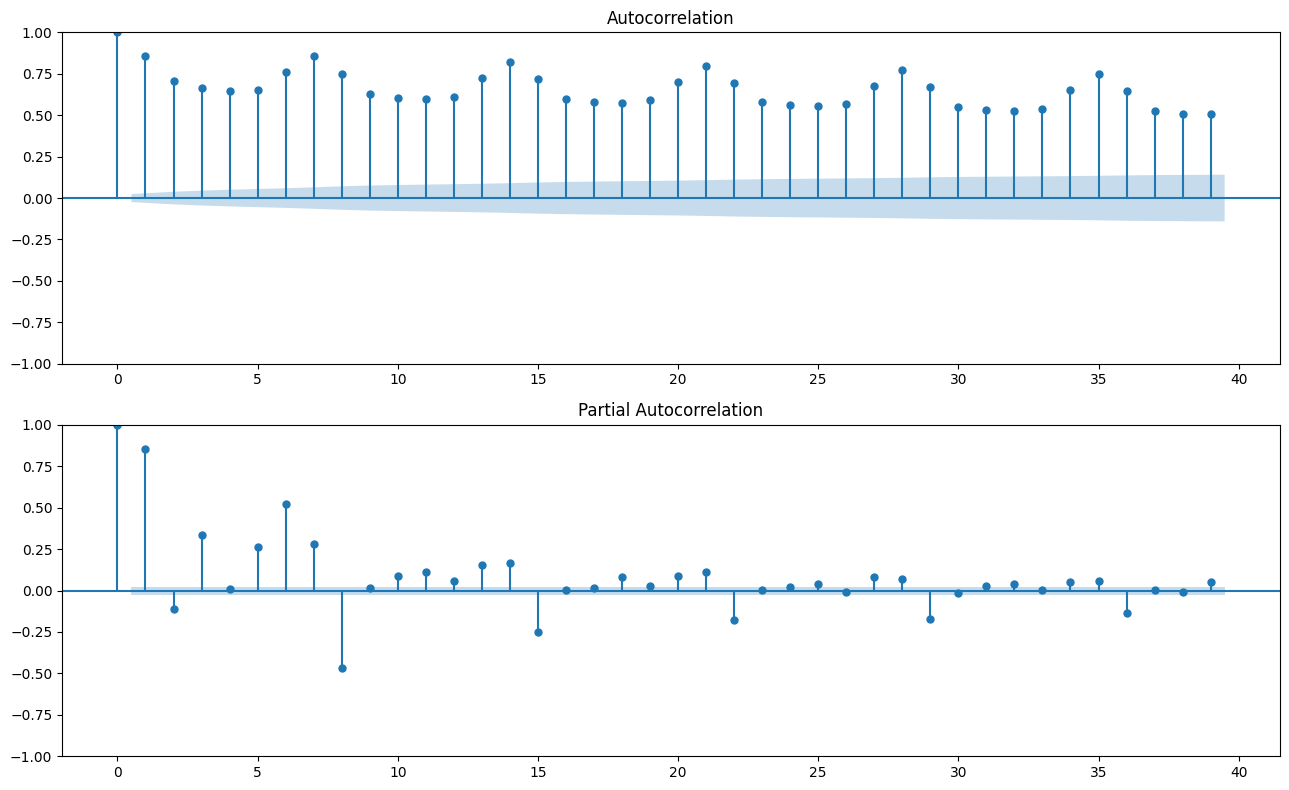

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(13, 8))

# Perform autocorrelation and partial autocorrelation plots
plot_acf(e2_day, ax=axs[0])
axs[0].set_title('Autocorrelation')

plot_pacf(e2_day, ax=axs[1])
axs[1].set_title('Partial Autocorrelation')

# Adjust the layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

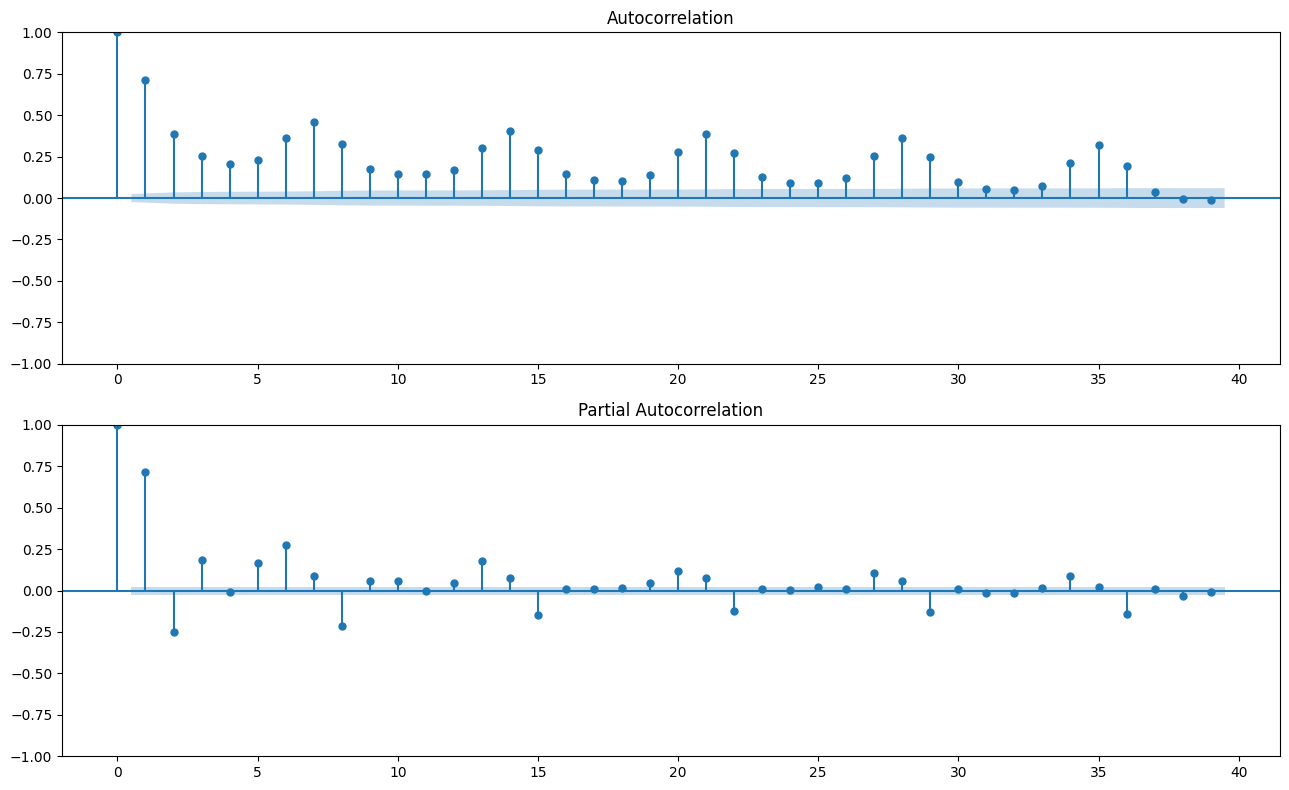

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(13, 8))

# Perform autocorrelation and partial autocorrelation plots
plot_acf(e3_day, ax=axs[0])
axs[0].set_title('Autocorrelation')

plot_pacf(e3_day, ax=axs[1])
axs[1].set_title('Partial Autocorrelation')

# Adjust the layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

El valor p se refiere al orden de la parte autorregresiva del modelo. Esta parte tiene en cuenta la relación lineal entre el valor actual de la serie temporal y sus valores anteriores. En otras palabras, 'p' indica cuántos períodos anteriores se deben incluir en el modelo para predecir el valor actual.


El parámetro 'q' se refiere al orden de la parte de media móvil del modelo. Este parámetro determina la cantidad de términos de error de pronóstico pasados que se incluyen en el modelo para capturar la componente de la media móvil y así mejorar la precisión del pronóstico.

El parámetro 'P' se refiere al orden de la parte autorregresiva estacional del modelo. Similar al parámetro 'p', pero en este caso, se centra en la relación lineal entre el valor actual y sus valores anteriores a lo largo de períodos estacionales.

El parámetro 'Q' está relacionado con el orden de la parte de media móvil estacional del modelo. Al igual que el parámetro 'q', pero se enfoca en capturar la componente de la media móvil a lo largo de períodos estacionales para mejorar la capacidad predictiva.

'D' representa el orden de diferenciación no estacional. Este parámetro indica cuántas veces debes diferenciar la serie temporal para hacerla estacionaria, es decir, para eliminar las tendencias y hacer que la varianza sea constante.

'm' denota la longitud de la estacionalidad en la serie temporal. Indica la cantidad de períodos en un ciclo estacional. Por ejemplo, si la serie temporal muestra una estacionalidad anual, 'm' sería 12.

De las gráficas de Autocorrelación y Autocorrelación Parcial obtenemos los valores $q$, $p$, $P$, $Q$, $m$ y $D$ respectivamente.

* $q$ , $Q$ : se va utizar los valores entre 0 y4 ya que son los puntos más altos en las gráficas de auto correlación.
* $p$ , $P$ : se va utizar los valores entre 0 y4 ya que son los puntos más altos en las gráficas de auto correlación.
* $m$ : Se puede observar que cada 6 meses hay un cambio pico por lo que este será nuestro valor de temporalidad.
* $D$ : aplicaremos una diferenciación por temporalidad una unica vez.

## **Modelo Sarimax**

In [ ]:
def optimize_SARIMAX(endog: Union[pd.Series, list],
                     exog: Union[pd.Series, list],
                     order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC',
                                      ascending=True).reset_index(drop=True)

    return result_df

### Análisis de variables exógenas

In [ ]:
target = e1_day
exog = t1_day[['DewTemperature', 'WetBulbTemperature', 'StationPressure', 'WindSpeed']]

train_size = int(len(e1_day) * 0.92)
target_train = target[:train_size]
exog_train = exog[:train_size]

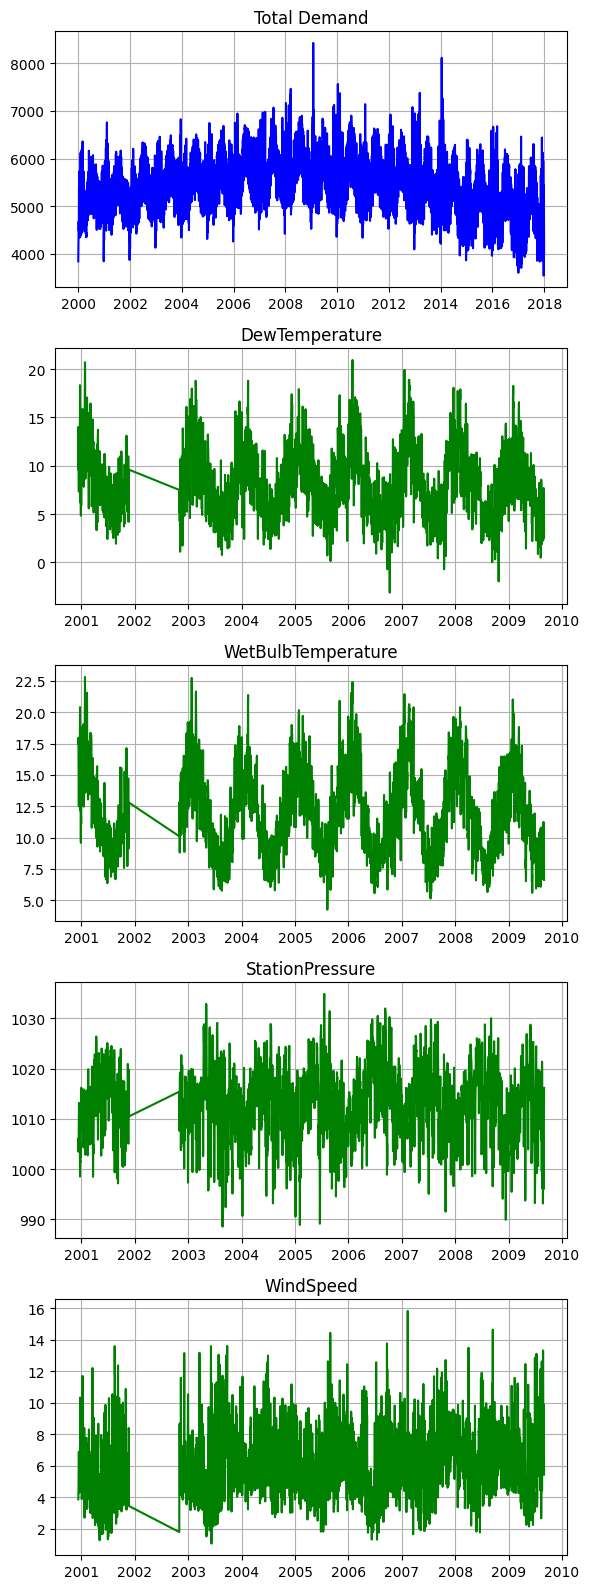

In [ ]:
# Crear gráficas
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 16))  # Ajusta el tamaño según sea necesario

# Graficar la variable objetivo
axes[0].plot(target, color='blue')
axes[0].set_title('Total Demand')
axes[0].grid(True)

# Graficar las variables exógenas
for i, col in enumerate(exog.columns):
    axes[i+1].plot(exog[col], color='green')
    axes[i+1].set_title(col)
    axes[i+1].grid(True)

plt.tight_layout()
plt.show()

Se observa que hay entre los años de 2002 y 2003 hay una carencia de datos por lo que vamos a comenzar el análisis desde el 2003.

In [ ]:
target = e1_day['2003':'2009'][:2436]
exog = t1_day['2003':'2009'][['DewTemperature', 'WetBulbTemperature', 'StationPressure', 'WindSpeed']]

train_size = int(len(e1_day['2003':'2009'][:2436]) * 0.92)
target_train = target[:train_size]
exog_train = exog[:train_size]

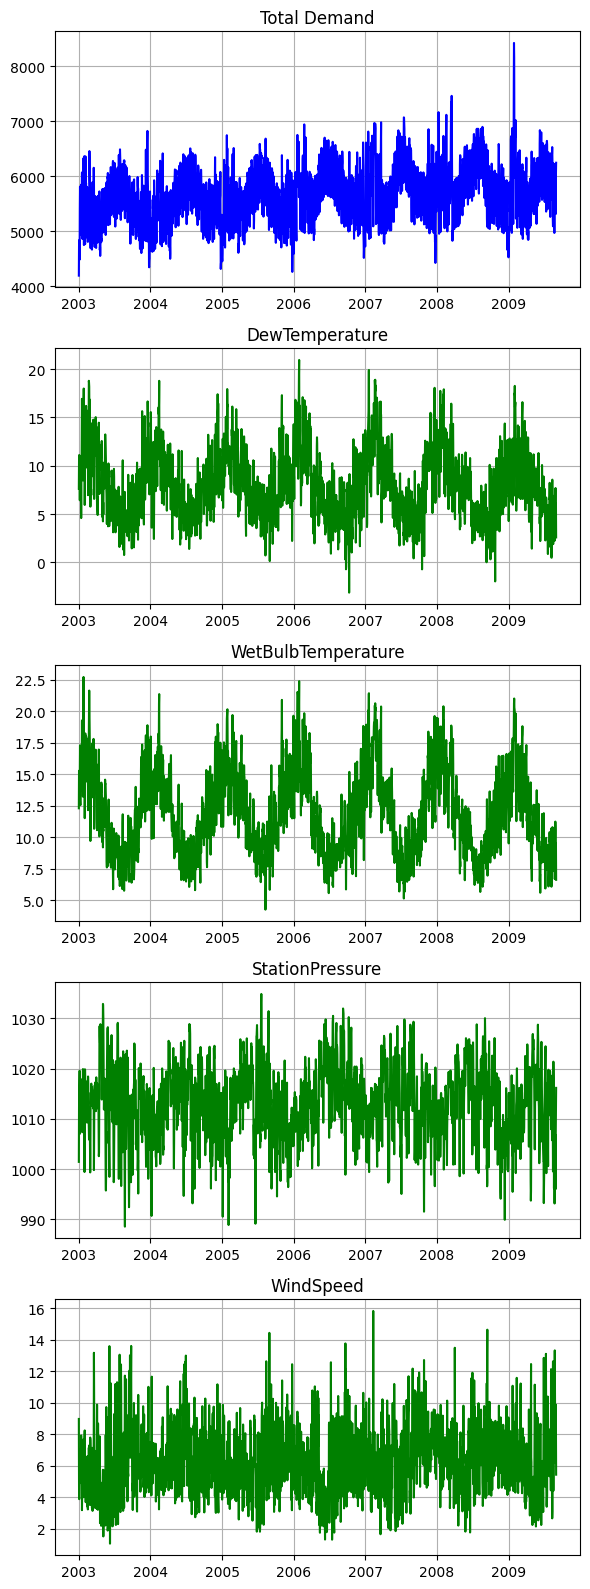

In [ ]:
# Crear gráficas
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 16))  # Ajusta el tamaño según sea necesario

# Graficar la variable objetivo
axes[0].plot(target, color='blue')
axes[0].set_title('Total Demand')
axes[0].grid(True)

# Graficar las variables exógenas
for i, col in enumerate(exog.columns):
    axes[i+1].plot(exog[col], color='green')
    axes[i+1].set_title(col)
    axes[i+1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
target2 = e2_day['2011-04-01':'2017-10-15'][:1025]
exog2 = t2_day['2011':'2017'][['DewTemperature', 'WetBulbTemperature', 'StationPressure', 'WindSpeed']]

train_size = int(len(e2_day['2011-04-01':'2017-10-15'][:1025]) * 0.92)
target_train2 = target2.iloc[:train_size]
exog_train2 = exog2.iloc[:train_size]

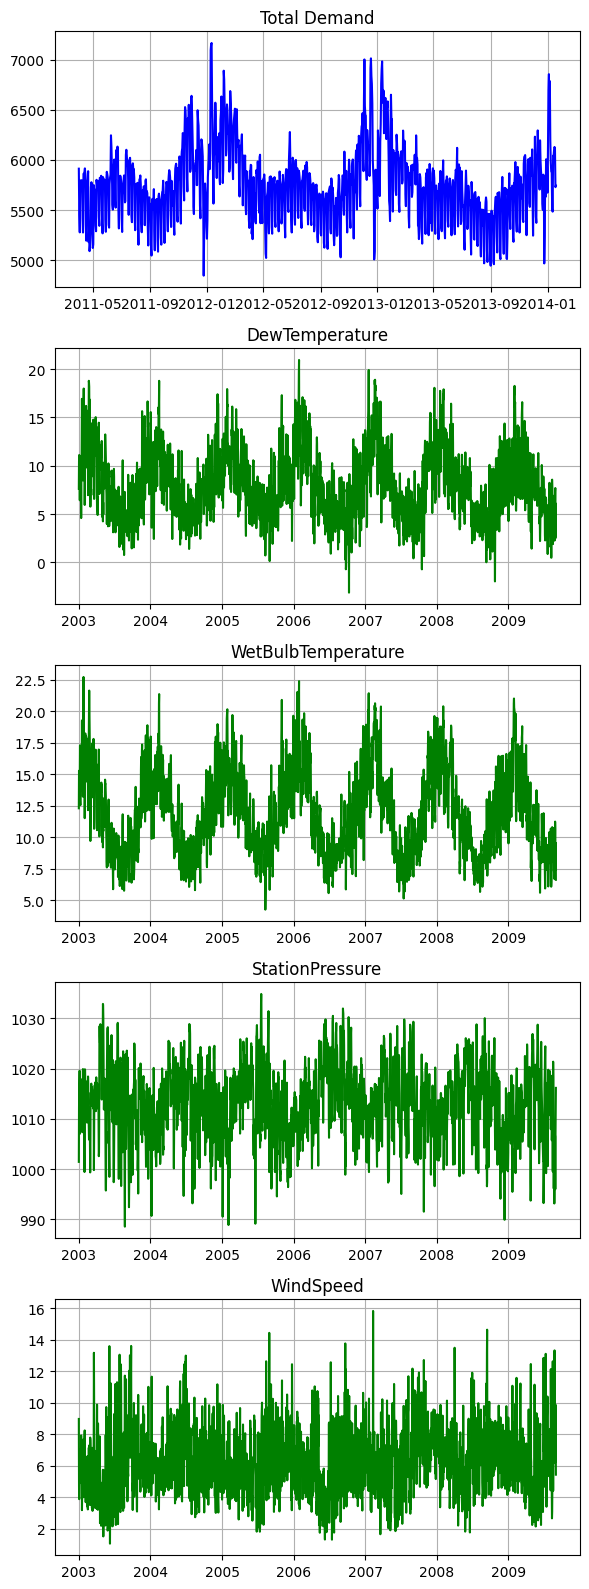

In [ ]:
# Crear gráficas
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 16))  # Ajusta el tamaño según sea necesario

# Graficar la variable objetivo
axes[0].plot(target2, color='blue')
axes[0].set_title('Total Demand')
axes[0].grid(True)

# Graficar las variables exógenas
for i, col in enumerate(exog2.columns):
    axes[i+1].plot(exog[col], color='green')
    axes[i+1].set_title(col)
    axes[i+1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
target3 = e3_day['2001-11-06':'2012-11-25'][:4034]
exog3 = t3_day[['DewTemperature', 'WetBulbTemperature', 'StationPressure', 'WindSpeed']]

train_size = int(len(e3_day['2001-11-06':'2012-11-25'][:4034]) * 0.92)
target_train3 = target3[:train_size]
exog_train3 = exog3[:train_size]

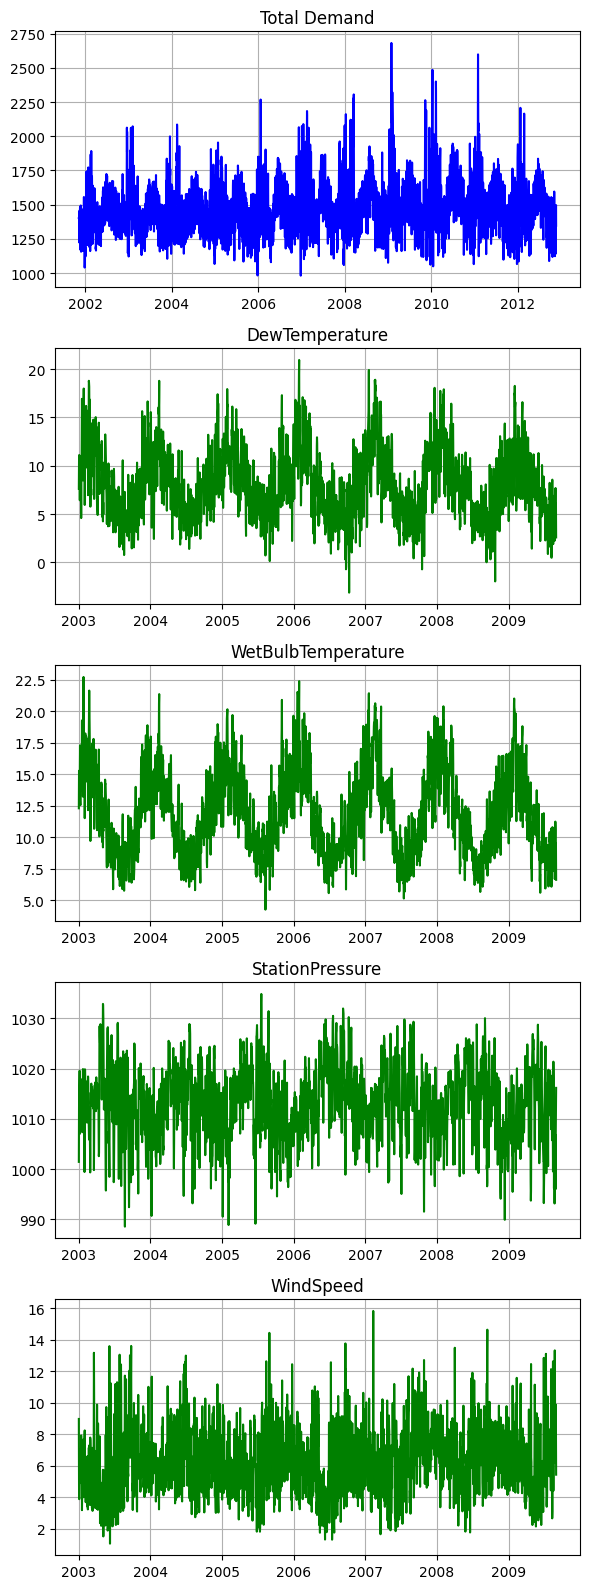

In [ ]:
# Crear gráficas
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 16))  # Ajusta el tamaño según sea necesario

# Graficar la variable objetivo
axes[0].plot(target3, color='blue')
axes[0].set_title('Total Demand')
axes[0].grid(True)

# Graficar las variables exógenas
for i, col in enumerate(exog3.columns):
    axes[i+1].plot(exog[col], color='green')
    axes[i+1].set_title(col)
    axes[i+1].grid(True)

plt.tight_layout()
plt.show()

### Valores de p, q, P Q

In [ ]:
p = range(0, 4, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 6

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 3, 0, 3)",26.00
1,"(3, 3, 2, 3)",31950.56
2,"(3, 2, 0, 3)",32106.57
3,"(3, 2, 3, 3)",32193.64
4,"(3, 3, 3, 3)",32199.24
...,...,...
251,"(0, 0, 3, 0)",33896.06
252,"(0, 0, 2, 0)",33967.07
253,"(0, 0, 0, 1)",34028.83
254,"(0, 0, 1, 0)",34136.00


### Ajuste del modelo

                                      SARIMAX Results                                      
Dep. Variable:                         TOTALDEMAND   No. Observations:                 2241
Model:             SARIMAX(2, 0, 3)x(0, 3, [1], 6)   Log Likelihood              -17520.064
Date:                             Fri, 01 Dec 2023   AIC                          35062.128
Time:                                     19:12:18   BIC                          35124.900
Sample:                                 01-01-2003   HQIC                         35085.053
                                      - 02-18-2009                                         
Covariance Type:                               opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
DewTemperature       -54.9416      4.367    -12.581      0.000     -63.501     -46.382
Wet

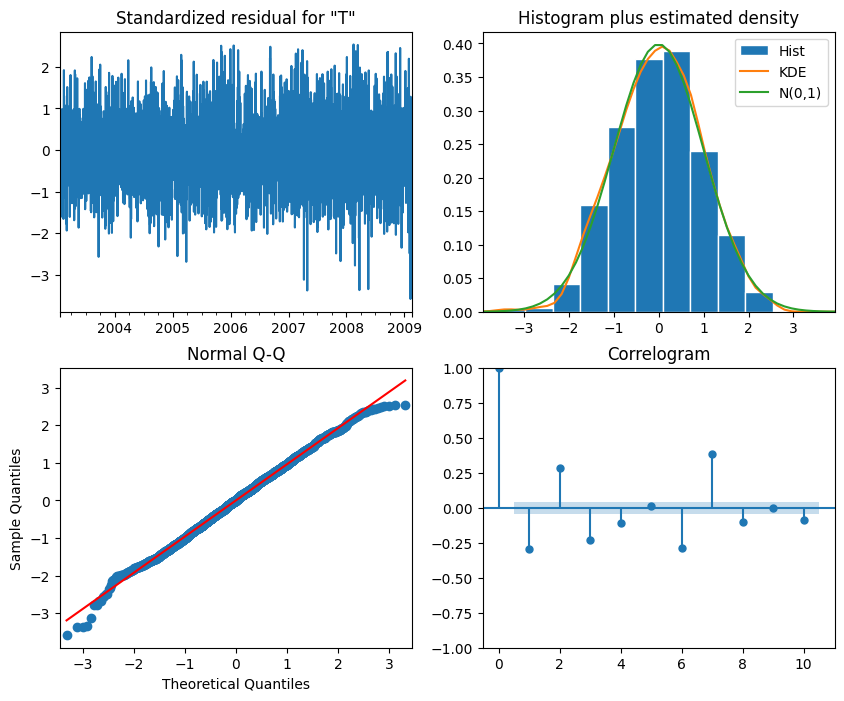

In [ ]:
SARIMAX_model = SARIMAX(target_train, exog_train, order=(2,0,3), seasonal_order=(0,3,1,6), simple_differencing=False)
SARIMAX_model_fit = SARIMAX_model.fit(disp=False)

print(SARIMAX_model_fit.summary())
SARIMAX_model_fit.plot_diagnostics(figsize=(10,8));

### Rolling Forecast

In [ ]:
def recursive_forecast_SARIMAX(endog: Union[pd.Series, list],
                               exog: Union[pd.Series, list],
                               train_len: int, horizon: int, window: int) -> list:

      pred_SARIMAX = []
      total_len = train_len + horizon

      for i in range(train_len, total_len, window):
          model = SARIMAX(endog[:i], exog[:i], order=(3,1,3),
                          seasonal_order=(0,0,0,4), simple_differencing=False)
          res = model.fit(disp=False)
          predictions = res.get_prediction(exog=exog)
          oos_pred = predictions.predicted_mean.iloc[-window:]
          pred_SARIMAX.extend(oos_pred)

      return pred_SARIMAX

In [ ]:
target_train

SETTLEMENTDATE
2003-01-01   4192.88
2003-01-02   4726.89
2003-01-03   4839.75
2003-01-04   4522.15
2003-01-05   4484.05
               ...  
2009-02-14   5290.47
2009-02-15   5062.83
2009-02-16   6052.68
2009-02-17   6261.20
2009-02-18   6308.65
Name: TOTALDEMAND, Length: 2241, dtype: float64

In [ ]:
target_st = target.iloc[2241:2251]

In [ ]:
target_st = target[train_size:]

In [ ]:
target_train

In [ ]:
TRAIN_LEN = len(target_train)
HORIZON = len(target_st)
print(HORIZON)
WINDOW = 1
pred_SARIMAX = recursive_forecast_SARIMAX(target_train, exog_train, TRAIN_LEN, HORIZON, WINDOW)

fechas = target_st.index
st_pred_SARIMAX = pd.Series(pred_SARIMAX[:len(fechas)], index=fechas)

mse_SARIMAX = mean_squared_error(target_st, st_pred_SARIMAX)
rmse_SARIMAX = np.sqrt(mse_SARIMAX)

mse_SARIMAX, rmse_SARIMAX

10


(337946.38453136216, 581.3315616163999)

## Visualización de predicciones

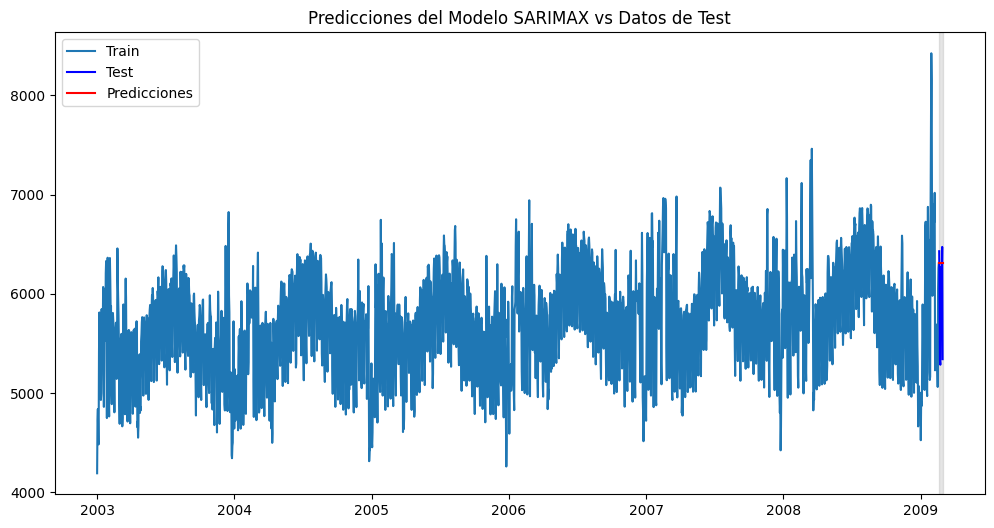

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(target_train,label='Train')
ax.plot(target_st, label='Test', color='blue')
ax.plot(st_pred_SARIMAX, label='Predicciones', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo SARIMAX vs Datos de Test')


fecha_inicio = target_st.index[0]
fecha_fin = target_st.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)

# **Conclusiones**

* Se identificaron relaciones significativas entre variables climáticas y consumo de energía en Australia. Este hallazgo subraya la influencia directa de las condiciones climáticas en los patrones de consumo de energía en el país. Esta comprensión mejora la capacidad para anticipar y planificar estrategias energéticas, lo que contribuye a una gestión más eficiente y sostenible de los recursos energéticos en el contexto australiano.

* Se observaron correlaciones positivas/negativas que proporcionaron información valiosa sobre la influencia del clima en la demanda energética. Estas relaciones ayudaron a comprender mejor cómo las condiciones climáticas afectan el consumo de energía en el contexto del análisis realizado.

* Se obtuvo la confirmación de estacionaridad en las series temporales de consumo de energía. Este hallazgo refuerza la robustez de nuestro análisis, proporcionando una base sólida para la aplicación de modelos temporales y la realización de pronósticos precisos.

* Se llevó a cabo un análisis detallado de la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF) para identificar los parámetros óptimos del modelo SARIMAX. Este análisis proporcionó información clave para la optimización del modelo y contribuyó a su ajuste preciso. En consecuencia, se fortaleció la capacidad del modelo para realizar pronósticos precisos en las series temporales de consumo de energía.

* Por ultimo, dado que en el análisis de la matriz de correlación se observó una correlación relativamente baja, específicamente de 0.17 la temperatura puede tener un impacto limitado en la predicción final de las series de tiempo de consumo de energía.
